In [1]:
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

from time import time
from io import StringIO
import sys, os
from tqdm import tqdm

from itertools import product
from pathlib import Path

import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

from utils4t import MultipleTimeSeriesCV, format_time

sys.path.insert(1, os.path.join(sys.path[0], '..'))

sns.set_style('whitegrid')
np.random.seed(42)

YEAR = 252
idx = pd.IndexSlice
DATA_DIR = Path('data')

results_path = Path('results', 'return_predictions')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [2]:
# load feature engineering
data = pd.read_hdf(DATA_DIR / 'data.h5', 'stooq/japan/equities')
data.info(null_counts=True), len(data.index.unique('ticker'))

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3081645 entries, ('9984.JP', Timestamp('2010-01-04 00:00:00')) to ('3053.JP', Timestamp('2023-05-01 00:00:00'))
Data columns (total 23 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   ret_1            3080700 non-null  float64
 1   ret_rel_perc_1   3080700 non-null  float64
 2   ret_5            3076920 non-null  float64
 3   ret_rel_perc_5   3076920 non-null  float64
 4   ret_10           3072195 non-null  float64
 5   ret_rel_perc_10  3072195 non-null  float64
 6   ret_21           3061800 non-null  float64
 7   ret_rel_perc_21  3061800 non-null  float64
 8   ret_63           3022110 non-null  float64
 9   ret_rel_perc_63  3022110 non-null  float64
 10  PPO              3058020 non-null  float64
 11  NATR             3068415 non-null  float64
 12  RSI              3068415 non-null  float64
 13  bbl              3077865 non-null  float64
 14  bbu              3077865 non-nul

(None, 945)

In [3]:
data.tail()

ret_1  ret_rel_perc_1     ret_5  ret_rel_perc_5  \
ticker  date                                                             
3053.JP 2023-04-25 -0.006135             3.0 -0.024096             1.0   
        2023-04-26 -0.006173            12.0 -0.024242             3.0   
        2023-04-27  0.018634            18.0  0.000000            10.0   
        2023-04-28 -0.012195             0.0  0.006211             6.0   
        2023-05-01  0.012346            12.0  0.006135             5.0   

                      ret_10  ret_rel_perc_10    ret_21  ret_rel_perc_21  \
ticker  date                                                               
3053.JP 2023-04-25  0.000000              3.0 -0.074286              0.0   
        2023-04-26 -0.006173              5.0 -0.085227              0.0   
        2023-04-27  0.018634             11.0 -0.057471              1.0   
        2023-04-28  0.006211              5.0 -0.058140              0.0   
        2023-05-01  0.012346              5.0 -0.057471              1.0   

                      ret_63  ret_rel_perc_63  ...       bbl       bbu  \
ticker  date                                   ...                       
3053.JP 2023-04-25 -0.079545              1.0  ...  1.011415  1.023632   
        2023-04-26 -0.090395              1.0  ...  1.007083  1.021940   
        2023-04-27 -0.068182              2.0  ...  1.025849  1.003246   
        2023-04-28 -0.074286              1.0  ...  1.010225  1.015059   
        2023-05-01 -0.073446              1.0  ...  1.023720  1.006098   

                    weekday  month  year  fwd_ret_01  fwd_ret_05  fwd_ret_10  \
ticker  date                                                                   
3053.JP 2023-04-25        1      4  2023   -0.006173         NaN         NaN   
        2023-04-26        2      4  2023    0.018634         NaN         NaN   
        2023-04-27        3      4  2023   -0.012195         NaN         NaN   
        2023-04-28        4      4  2023    0.012346         NaN         NaN   
        2023-05-01        0      5  2023         NaN         NaN         NaN   

                    fwd_ret_21  fwd_ret_63  
ticker  date                                
3053.JP 2023-04-25         NaN         NaN  
        2023-04-26         NaN         NaN  
        2023-04-27         NaN         NaN  
        2023-04-28         NaN         NaN  
        2023-05-01         NaN         NaN  

[5 rows x 23 columns]

In [4]:
prices = (pd.read_hdf(DATA_DIR / 'assets.h5', 'stooq/jp/tse/stocks/prices').loc[idx[:, '2010':'2023'], :])
prices.tail()

open   high    low  close    volume
ticker  date                                            
9997.JP 2023-04-25  727.0  734.0  724.0  727.0  125600.0
        2023-04-26  728.0  738.0  726.0  734.0  150100.0
        2023-04-27  733.0  733.0  727.0  732.0   73800.0
        2023-04-28  738.0  745.0  738.0  745.0  127000.0
        2023-05-01  749.0  753.0  741.0  746.0  131200.0

In [6]:
dollar_vol = prices.close.mul(prices.volume)
dollar_vol_rank = dollar_vol.groupby(level='date').rank(ascending=False)
universe = dollar_vol_rank.groupby(level='ticker').mean().nsmallest(250).index
universe[-10:]

Index(['6472.JP', '6448.JP', '9513.JP', '8354.JP', '3861.JP', '7911.JP',
       '4182.JP', '6963.JP', '7936.JP', '4768.JP'],
      dtype='object', name='ticker')


In [7]:
cv = MultipleTimeSeriesCV(n_splits=36, test_period_length=21, lookahead=5, train_period_length=2 * YEAR)

for i, (train_idx, test_idx) in enumerate(cv.split(X=data)):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('date')
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('date')
    df = train.reset_index().append(test.reset_index())
    n = len(df)
    assert n == len(df.drop_duplicates())
    msg = f'Training: {train_dates.min().date()} ~ {train_dates.max().date()}'
    msg += f'({train.groupby(level="ticker").size().value_counts().index[0]:,.0f} days)|'
    msg += f'Test: {test_dates.min().date()} ~ {test_dates.max().date()}'
    msg += f'({test.groupby(level="ticker").size().value_counts().index[0]:,.0f} days)'
    print(msg)
    # if i % 6:
    #     break

Training: 2021-03-01 ~ 2023-03-27(508 days)|Test: 2023-04-03 ~ 2023-05-01(21 days)
Training: 2021-01-27 ~ 2023-02-22(508 days)|Test: 2023-03-02 ~ 2023-03-31(21 days)
Training: 2020-12-24 ~ 2023-01-24(508 days)|Test: 2023-01-31 ~ 2023-03-01(21 days)
Training: 2020-11-25 ~ 2022-12-21(508 days)|Test: 2022-12-28 ~ 2023-01-30(21 days)
Training: 2020-10-23 ~ 2022-11-21(508 days)|Test: 2022-11-29 ~ 2022-12-27(21 days)
Training: 2020-09-23 ~ 2022-10-20(508 days)|Test: 2022-10-27 ~ 2022-11-28(21 days)
Training: 2020-08-21 ~ 2022-09-16(508 days)|Test: 2022-09-27 ~ 2022-10-26(21 days)
Training: 2020-07-20 ~ 2022-08-18(508 days)|Test: 2022-08-25 ~ 2022-09-26(21 days)
Training: 2020-06-19 ~ 2022-07-19(508 days)|Test: 2022-07-26 ~ 2022-08-24(21 days)
Training: 2020-05-21 ~ 2022-06-17(508 days)|Test: 2022-06-24 ~ 2022-07-25(21 days)
Training: 2020-04-16 ~ 2022-05-19(508 days)|Test: 2022-05-26 ~ 2022-06-23(21 days)
Training: 2020-03-17 ~ 2022-04-14(508 days)|Test: 2022-04-21 ~ 2022-05-25(21 days)
Trai

In [8]:
 data.loc[idx[universe, :'2020'], :]

UnsortedIndexError: 'MultiIndex slicing requires the index to be lexsorted: slicing on levels [1], lexsort depth 0'

In [9]:
data = data.sort_index()
cv_data = data.loc[idx[universe, : '2022'], :]
tickers = cv_data.index.unique('ticker')

In [10]:
cv_data.tail()

ret_1  ret_rel_perc_1     ret_5  ret_rel_perc_5  \
ticker  date                                                             
4768.JP 2022-12-26 -0.001190             5.0 -0.032295             6.0   
        2022-12-27  0.002384             8.0  0.003580            10.0   
        2022-12-28  0.001189            11.0  0.013237            10.0   
        2022-12-29 -0.019002             2.0 -0.021327             3.0   
        2022-12-30  0.006053            15.0 -0.010714             3.0   

                      ret_10  ret_rel_perc_10    ret_21  ret_rel_perc_21  \
ticker  date                                                               
4768.JP 2022-12-26 -0.030058              8.0 -0.104589              3.0   
        2022-12-27 -0.027746              8.0 -0.094726              4.0   
        2022-12-28 -0.045351              6.0 -0.093649              3.0   
        2022-12-29 -0.048387              6.0 -0.096280              3.0   
        2022-12-30 -0.047018              5.0 -0.082781              4.0   

                      ret_63  ret_rel_perc_63  ...       bbl       bbu  \
ticker  date                                   ...                       
4768.JP 2022-12-26 -0.045506              7.0  ...  1.010901  1.009353   
        2022-12-27 -0.038857              5.0  ...  1.012853  1.007933   
        2022-12-28 -0.042093              5.0  ...  1.005062  1.003136   
        2022-12-29 -0.070866              3.0  ...  1.000207  1.028294   
        2022-12-30 -0.083793              3.0  ...  1.009332  1.020799   

                    weekday  month  year  fwd_ret_01  fwd_ret_05  fwd_ret_10  \
ticker  date                                                                   
4768.JP 2022-12-26        0     12  2022    0.002384   -0.026222   -0.009535   
        2022-12-27        1     12  2022    0.001189   -0.015458   -0.035672   
        2022-12-28        2     12  2022   -0.019002   -0.015439   -0.030879   
        2022-12-29        3     12  2022    0.006053    0.014528   -0.014528   
        2022-12-30        4     12  2022   -0.016847    0.006017   -0.006017   

                    fwd_ret_21  fwd_ret_63  
ticker  date                                
4768.JP 2022-12-26    0.015495    0.109654  
        2022-12-27    0.015458    0.114150  
        2022-12-28    0.010689    0.121140  
        2022-12-29    0.043584    0.116223  
        2022-12-30    0.115523    0.078219  

[5 rows x 23 columns]

In [11]:
cv_data.to_hdf(DATA_DIR / 'data.h5', 'stooq/japan/equities/cv_data')

with pd.HDFStore(DATA_DIR / 'data.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: data\data.h5
/lasso/coeffs                            frame        (shape->[8,34])      
/lasso/predictions                       frame        (shape->[592432,3])  
/lasso/scores                            frame        (shape->[6000,3])    
/logistic/coeffs                         frame        (shape->[11,34])     
/logistic/predictions                    frame        (shape->[814594,4])  
/logistic/scores                         frame        (shape->[825,5])     
/lr/predictions                          frame        (shape->[74054,2])   
/lr/scores                               frame        (shape->[750,2])     
/model_data                              frame        (shape->[2904233,70])
/ridge/coeffs                            frame        (shape->[18,34])     
/ridge/predictions                       frame        (shape->[1332972,3]) 
/ridge/scores                            frame        (shape->[13500,3])   
/stooq/japan/equities     

In [13]:
lookaheads = [1, 5, 10, 21]

lr = LinearRegression()

labels = sorted(cv_data.filter(like='fwd').columns)
features = cv_data.columns.difference(labels).tolist()

In [14]:
# labels
features

['NATR',
 'PPO',
 'RSI',
 'bbl',
 'bbu',
 'month',
 'ret_1',
 'ret_10',
 'ret_21',
 'ret_5',
 'ret_63',
 'ret_rel_perc_1',
 'ret_rel_perc_10',
 'ret_rel_perc_21',
 'ret_rel_perc_5',
 'ret_rel_perc_63',
 'weekday',
 'year']

In [15]:
# CV Parameters
train_lengths = [5 * YEAR, 3 * YEAR, YEAR, 126, 63]
test_lengths = [5, 21]

test_params = list(product(lookaheads, train_lengths, test_lengths))

lr_metrics = []
for lookahead, train_length, test_length in tqdm(test_params):
    label = f'fwd_ret_{lookahead:02}'
    df = cv_data.loc[:, features + [label]].dropna()
    X, y = df.drop(label, axis=1), df[label]

    n_splits = int(2 * YEAR / test_length)
    cv = MultipleTimeSeriesCV(n_splits=n_splits, test_period_length=test_length, lookahead=lookahead,
                              train_period_length=train_length)
    ic, preds = [], []
    for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        preds.append(y_test.to_frame('y_true').assign(y_pred=y_pred))
        ic.append(spearmanr(y_test, y_pred)[0])
    preds = pd.concat(preds)
    lr_metrics.append([lookahead, train_length, test_length,np.mean(ic),
        spearmanr(preds.y_true, preds.y_pred)[0]])

columns = ['lookahead', 'train_length', 'test_length', 'ic_by_day', 'ic']
lr_metrics = pd.DataFrame(lr_metrics, columns=columns)
lr_metrics.info()

100%|██████████| 40/40 [02:52<00:00,  4.32s/it]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lookahead     40 non-null     int64  
 1   train_length  40 non-null     int64  
 2   test_length   40 non-null     int64  
 3   ic_by_day     40 non-null     float64
 4   ic            40 non-null     float64
dtypes: float64(2), int64(3)
memory usage: 1.7 KB


In [17]:
lr_metrics_long = pd.concat([(lr_metrics.drop('ic', axis=1).rename(columns={'ic_by_day': 'ic'})
                              .assign(Measured='By Day')),lr_metrics.drop('ic_by_day', axis=1)
                             .assign(Measured='Overall')])
lr_metrics_long.columns=['Lookahead', 'Train Length', 'Test Length', 'IC', 'Measure']
lr_metrics_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 0 to 39
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Lookahead     80 non-null     int64  
 1   Train Length  80 non-null     int64  
 2   Test Length   80 non-null     int64  
 3   IC            80 non-null     float64
 4   Measure       80 non-null     object 
dtypes: float64(1), int64(3), object(1)
memory usage: 3.8+ KB


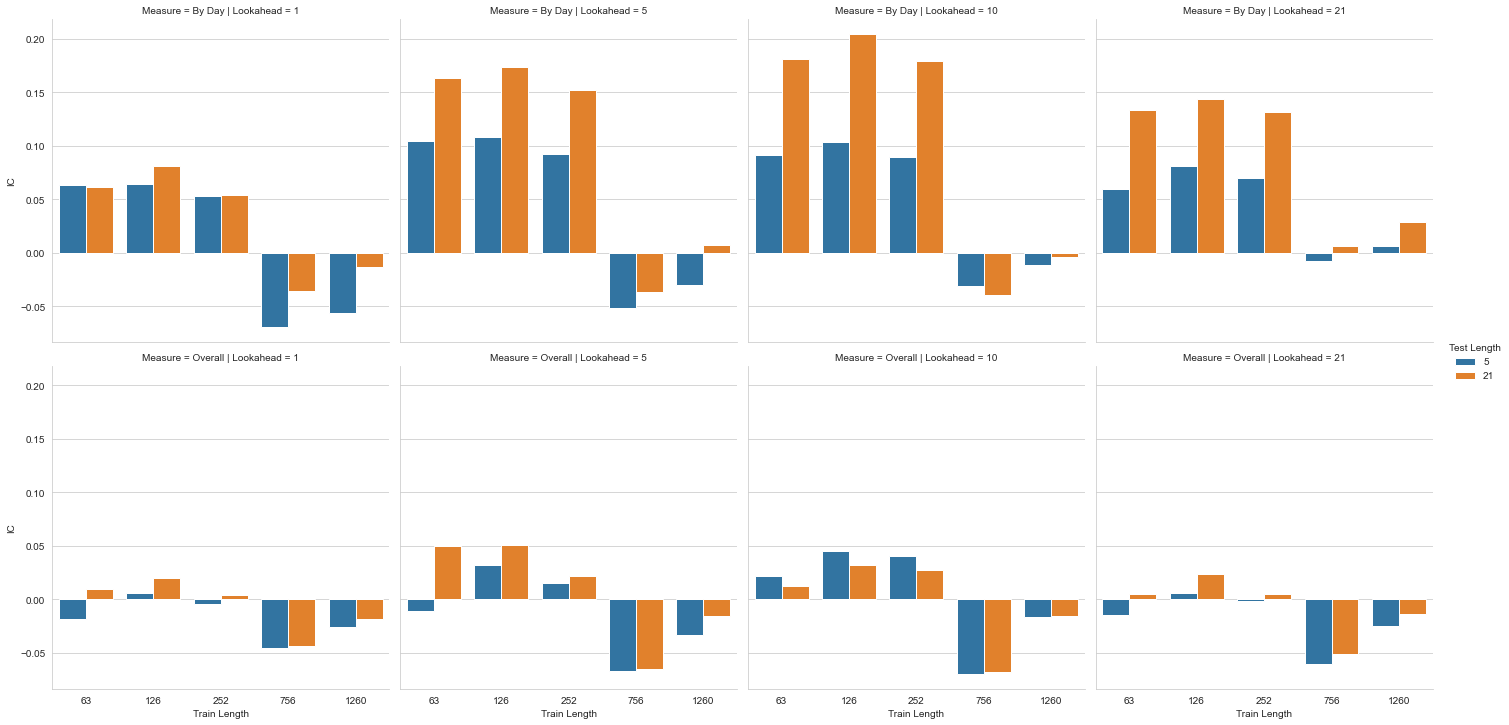

In [18]:
sns.catplot(x='Train Length', y='IC', hue='Test Length', col='Lookahead', row='Measure', data=lr_metrics_long,
            kind='bar')

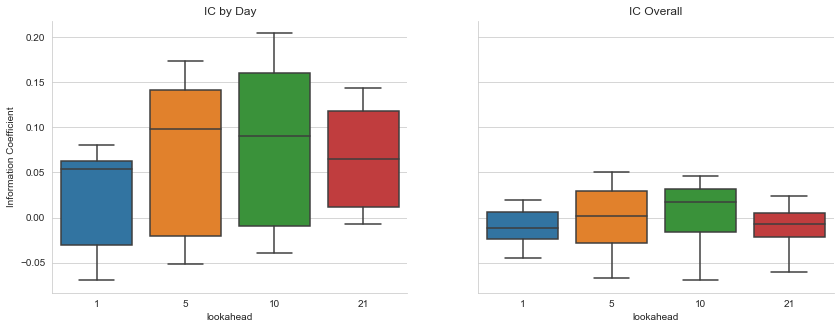

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5), sharey=True)
sns.boxplot(x='lookahead', y='ic_by_day', data=lr_metrics, ax=axes[0])
axes[0].set_title('IC by Day')
sns.boxplot(x='lookahead', y='ic', data=lr_metrics, ax=axes[1])
axes[1].set_title('IC Overall')
axes[0].set_ylabel('Information Coefficient')
axes[1].set_ylabel('')
sns.despine()

In [20]:
# Best Train/Test Period Lengths
(lr_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic')))

,lookahead,train_length,test_length,ic_by_day,ic
7,1,126,21,0.080675,0.019717
9,1,63,21,0.061224,0.010180
6,1,126,5,0.064660,0.006399
17,5,126,21,0.173173,0.050901
19,5,63,21,0.163050,0.049575
16,5,126,5,0.108005,0.032094
26,10,126,5,0.103205,0.045533
24,10,252,5,0.089432,0.040674
27,10,126,21,0.204365,0.032537
37,21,126,21,0.143643,0.023799


In [21]:
lr_metrics.to_csv(results_path / 'lin_reg_performance.csv', index=False)

In [22]:
# LightGBM Random Forest MDL Tuning
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(), index=model.feature_name()))



base_params = dict(boosting_type='rf', objective='regression', bagging_freq=1, verbose=-1)

bagging_fraction_opts = [.5, .75, .95]
feature_fraction_opts = [.75, .95]
min_data_in_leaf_opts = [250, 500, 1000]


cv_params = list(product(bagging_fraction_opts, feature_fraction_opts, min_data_in_leaf_opts))
n_cv_params = len(cv_params)
n_cv_params

18

In [23]:
sample_proportion = .5
sample_size = int(sample_proportion * n_cv_params)

cv_param_sample = np.random.choice(list(range(n_cv_params)), size=int(sample_size), replace=False)
cv_params_ = [cv_params[i] for i in cv_param_sample]
print(f'CV Parameters: {len(cv_params_)}')

CV Parameters: 9


In [24]:
num_iterations = [25] + list(range(50, 501, 25))
num_boost_round = num_iterations[-1]

train_lengths = [5 * YEAR, 3 * YEAR, YEAR, 126, 63]
test_lengths = [5, 21]
test_params = list(product(train_lengths, test_lengths))
n_test_params = len(test_params)

sample_proportion = 1.0
sample_size = int(sample_proportion * n_test_params)

test_param_sample = np.random.choice(list(range(n_test_params)), size=int(sample_size), replace=False)
test_params_ = [test_params[i] for i in test_param_sample]
print('Train configs:', len(test_params_))
print('CV Iterations:', len(cv_params_) * len(test_params_))

Train configs: 10
CV Iterations: 90


In [27]:
# categorical variables
categoricals = ['year', 'weekday', 'month']
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

labels = sorted(cv_data.filter(like='fwd').columns)
features = cv_data.columns.difference(labels).tolist()
label_dict = dict(zip(lookaheads, labels))
cv_store = Path(results_path / 'parameter_tuning.h5')
ic_cols = ['bagging_fraction', 'feature_fraction', 'min_data_in_leaf', 't'] + [str(n) for n in num_iterations]

In [29]:
for lookahead in lookaheads:
    for train_length, test_length in test_params_:
        n_splits = int(2 * YEAR / test_length)
        print(f'Lookahead: {lookahead:2.0f} | Train: {train_length:3.0f} | '
              f'Test: {test_length:2.0f} | Params: {len(cv_params_):3.0f}')

        cv = MultipleTimeSeriesCV(n_splits=n_splits, test_period_length=test_length,
                                  train_period_length=train_length, lookahead=lookahead)
        label = label_dict[lookahead]
        outcome_data = data.loc[:, features + [label]].dropna()

        lgb_data = lgb.Dataset(data=outcome_data.drop(label, axis=1), label=outcome_data[label],
                               categorical_feature=categoricals, free_raw_data=False)
        predictions, daily_ic, ic, feature_importance = [], [], [], []
        key = f'{lookahead}/{train_length}/{test_length}'
        T = 0
        for p, (bagging_fraction, feature_fraction, min_data_in_leaf) in enumerate(cv_params_):
            params = base_params.copy()
            params.update(dict(bagging_fraction=bagging_fraction, feature_fraction=feature_fraction,
                               min_data_in_leaf=min_data_in_leaf))

            start = time()
            cv_preds, nrounds = [], []
            for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
                lgb_train = lgb_data.subset(used_indices=train_idx.tolist(), params=params).construct()
                lgb_test = lgb_data.subset(used_indices=test_idx.tolist(), params=params).construct()

                model = lgb.train(params=params, train_set=lgb_train, num_boost_round=num_boost_round,
                                  verbose_eval=False)
                if i == 0:
                    fi = get_fi(model).to_frame()
                else:
                    fi[i] = get_fi(model)


                test_set = outcome_data.iloc[test_idx, :]
                X_test = test_set.loc[:, model.feature_name()]
                y_test = test_set.loc[:, label]
                y_pred = {str(n): model.predict(X_test, num_iteration=n) for n in num_iterations}
                cv_preds.append(y_test.to_frame('y_test').assign(**y_pred).assign(i=i))
                nrounds.append(model.best_iteration)
            feature_importance.append(fi.T.describe().T.assign(bagging_fraction=bagging_fraction,
                                                               feature_fraction=feature_fraction,
                                                               min_data_in_leaf=min_data_in_leaf))
            cv_preds = pd.concat(cv_preds).assign(bagging_fraction=bagging_fraction,
                                                  feature_fraction=feature_fraction,
                                                  min_data_in_leaf=min_data_in_leaf)
            predictions.append(cv_preds)
            by_day = cv_preds.groupby(level='date')
            ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test, x[str(n)])[0]).to_frame(n)
                                   for n in num_iterations], axis=1)

            daily_ic.append(ic_by_day.assign(bagging_fraction=bagging_fraction,
                                             feature_fraction=feature_fraction,
                                             min_data_in_leaf=min_data_in_leaf))

            cv_ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0] for n in num_iterations]

            T += time() - start
            ic.append([bagging_fraction, feature_fraction, min_data_in_leaf, lookahead] + cv_ic)

            msg = f'{p:3.0f} | {format_time(T)} | '
            msg += f'{bagging_fraction:3.0%} | {feature_fraction:3.0%} | {min_data_in_leaf:5,.0f} | '
            msg += f'{max(cv_ic):6.2%} | {ic_by_day.mean().max(): 6.2%} | {ic_by_day.median().max(): 6.2%}'
            print(msg)

        m = pd.DataFrame(ic, columns=ic_cols)
        m.to_hdf(cv_store, 'ic/' + key)
        pd.concat(daily_ic).to_hdf(cv_store, 'daily_ic/' + key)
        pd.concat(feature_importance).to_hdf(cv_store, 'fi/' + key)
        pd.concat(predictions).to_hdf(cv_store, 'predictions/' + key)

Lookahead:  1 | Train:  63 | Test: 21 | Params:   9
  0 | 00:01:09 | 50% | 75% |   250 | -1.56% |  0.64% |  0.70%
  1 | 00:02:18 | 50% | 75% |   500 | -2.70% |  0.73% |  1.14%
  2 | 00:03:22 | 75% | 75% | 1,000 | -2.74% |  0.75% |  1.10%
  3 | 00:04:21 | 50% | 95% | 1,000 | -3.29% |  0.48% |  0.77%
  4 | 00:05:26 | 50% | 95% |   250 | -1.76% |  0.43% |  0.64%
  5 | 00:06:30 | 95% | 75% |   500 | -1.11% |  0.30% |  0.92%
  6 | 00:07:35 | 95% | 95% |   500 | -1.05% |  0.09% |  0.30%
  7 | 00:08:44 | 95% | 95% |   250 | -1.27% |  0.41% |  0.82%
  8 | 00:09:49 | 75% | 95% | 1,000 | -2.83% |  0.59% |  1.02%
Lookahead:  1 | Train: 756 | Test:  5 | Params:   9
  0 | 00:14:24 | 50% | 75% |   250 | -2.48% | -1.36% | -0.98%
  1 | 00:29:21 | 50% | 75% |   500 | -2.46% | -1.17% | -1.25%
  2 | 00:44:36 | 75% | 75% | 1,000 | -1.87% | -1.04% | -1.10%
  3 | 01:01:17 | 50% | 95% | 1,000 | -2.19% | -1.02% | -1.01%
  4 | 01:16:27 | 50% | 95% |   250 | -2.29% | -1.01% | -0.58%
  5 | 01:30:10 | 95% | 75% |

In [30]:
id_vars = ['train_length', 'test_length', 'bagging_fraction', 'feature_fraction', 'min_data_in_leaf',
           't', 'date']

daily_ic, ic = [], []
for t in lookaheads:
    print(f'current lookaheads : {t}')
    with pd.HDFStore(cv_store) as store:
        keys = [k[1:] for k in store.keys() if k.startswith(f'/fi/{t}')]
        for key in keys:
            train_length, test_length = key.split('/')[2:]
            print(f'train_length: {train_length}, test_length: {test_length}')
            k = f'{t}/{train_length}/{test_length}'
            cols = {'t': t, 'train_length': int(train_length), 'test_length': int(test_length)}

            ic.append(pd.melt(store['ic/' + k].assign(**cols), id_vars=id_vars[:-1], value_name='ic',
                              var_name='rounds').apply(pd.to_numeric))

            df = store['daily_ic/' + k].assign(**cols).reset_index()
            daily_ic.append(pd.melt(df, id_vars=id_vars, value_name='daily_ic', var_name='rounds')
                            .set_index('date') .apply(pd.to_numeric) .reset_index())
ic = pd.concat(ic, ignore_index=True)
daily_ic = pd.concat(daily_ic, ignore_index=True)

current lookaheads : 1
train_length: 756, test_length: 21
train_length: 756, test_length: 5
train_length: 63, test_length: 21
train_length: 63, test_length: 5
train_length: 252, test_length: 21
train_length: 252, test_length: 5
train_length: 1260, test_length: 21
train_length: 1260, test_length: 5
train_length: 126, test_length: 21
train_length: 126, test_length: 5
train_length: 756, test_length: 21
train_length: 756, test_length: 5
train_length: 63, test_length: 21
train_length: 63, test_length: 5
train_length: 252, test_length: 21
train_length: 252, test_length: 5
train_length: 1260, test_length: 21
train_length: 1260, test_length: 5
train_length: 126, test_length: 21
train_length: 126, test_length: 5
current lookaheads : 5
train_length: 756, test_length: 21
train_length: 756, test_length: 5
train_length: 63, test_length: 21
train_length: 63, test_length: 5
train_length: 252, test_length: 21
train_length: 252, test_length: 5
train_length: 1260, test_length: 21
train_length: 1260, tes

In [31]:
group_cols = ['t','train_length', 'test_length',  'bagging_fraction', 'feature_fraction', 'min_data_in_leaf']
daily_ic_avg = daily_ic.groupby(group_cols + ['rounds']).daily_ic.mean().to_frame('ic').reset_index()
daily_ic_avg.groupby('t', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))

,t,train_length,test_length,bagging_fraction,feature_fraction,min_data_in_leaf,rounds,ic
802,1,252,5,0.75,0.75,1000,75,0.008282
803,1,252,5,0.75,0.75,1000,100,0.008101
804,1,252,5,0.75,0.75,1000,125,0.007659
3341,5,1260,5,0.75,0.95,1000,50,0.008518
2720,5,252,21,0.50,0.75,500,25,0.007703
3280,5,1260,5,0.50,0.95,250,25,0.007357
4633,10,252,21,0.95,0.75,500,350,0.021910
4636,10,252,21,0.95,0.75,500,425,0.021831
4637,10,252,21,0.95,0.75,500,450,0.021825
5594,21,63,21,0.50,0.75,250,375,0.035595


In [32]:
daily_ic_avg.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   t                 7200 non-null   int64  
 1   train_length      7200 non-null   int64  
 2   test_length       7200 non-null   int64  
 3   bagging_fraction  7200 non-null   float64
 4   feature_fraction  7200 non-null   float64
 5   min_data_in_leaf  7200 non-null   int64  
 6   rounds            7200 non-null   int64  
 7   ic                7200 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 450.1 KB


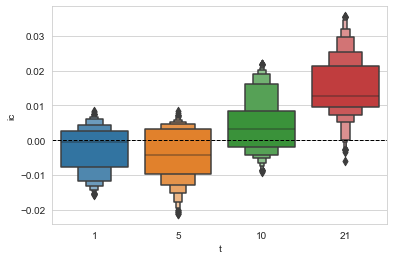

In [33]:
ax = sns.boxenplot(x='t', y='ic', data=daily_ic_avg)
ax.axhline(0, ls='--', lw=1, c='k');

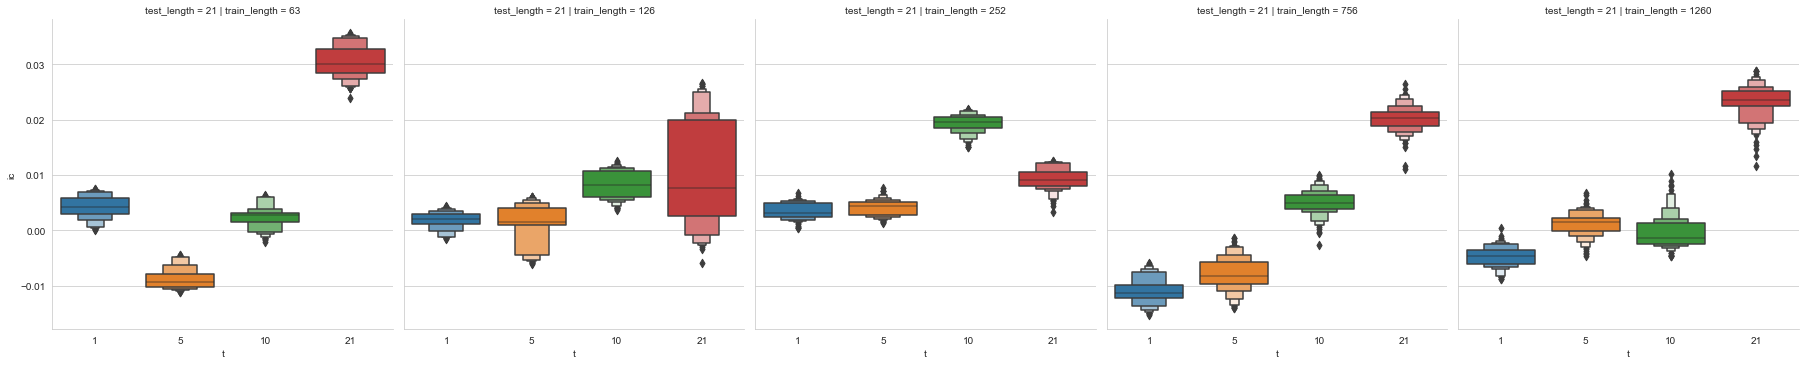

In [34]:
g = sns.catplot(x='t', y='ic', col='train_length', row='test_length',
                data=daily_ic_avg[(daily_ic_avg.test_length == 21)], kind='boxen')
g.savefig(results_path / 'daily_ic_test_21', dpi=300);

In [48]:
lin_reg = {}
for t in [1, 5]:
    df_ = daily_ic_avg[(daily_ic_avg.t==t)&(daily_ic_avg.rounds<=250)].dropna()
    y, X = df_.ic, df_.drop(['ic', 't'], axis=1)
    X = sm.add_constant(pd.get_dummies(X, columns=X.columns, drop_first=True))
    model = sm.OLS(endog=y, exog=X)
    lin_reg[t] = model.fit()
    s = lin_reg[t].summary()
    print(s)
    coefs = pd.read_csv(StringIO(s.tables[1].as_csv())).rename(columns=lambda x: x.strip())
    coefs.columns = ['variable', 'coef', 'std_err', 't', 'p_value', 'ci_low', 'ci_high']
    coefs.to_csv(results_path / f'lr_result_{t:02}.csv', index=False)

def visualize_lr_result(model, ax):
    ci = model.conf_int()
    errors = ci[1].sub(ci[0]).div(2)

    coefs = (model.params.to_frame('coef').assign(error=errors)
             .reset_index().rename(columns={'index': 'variable'}))
    coefs = coefs[~coefs['variable'].str.startswith('date') & (coefs.variable != 'const')]
    coefs.variable = coefs.variable.str.split('_').str[-1]

    coefs.plot(x='variable', y='coef', kind='bar', ax=ax,
               color='none', capsize=3, yerr='error', legend=False, rot=0)
    ax.set_ylabel('IC')
    ax.set_xlabel('')
    ax.scatter(x=pd.np.arange(len(coefs)), marker='_', s=120, y=coefs['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
    ax.xaxis.set_ticks_position('none')

    ax.annotate('Train\nLength', xy=(.09, -0.1), xytext=(.09, -0.2), xycoords='axes fraction',
                textcoords='axes fraction', fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=5, lengthB=0.8', lw=1.0, color='black'))

    ax.annotate('Test\nLength', xy=(.23, -0.1), xytext=(.23, -0.2), xycoords='axes fraction',
                textcoords='axes fraction', fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=2, lengthB=0.8', lw=1.0, color='black'))

    ax.annotate('Bagging\nFraction', xy=(.32, -0.1), xytext=(.32, -0.2), xycoords='axes fraction',
                textcoords='axes fraction', fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=2.7, lengthB=0.8', lw=1.0, color='black'))


    ax.annotate('Feature\nFraction', xy=(.44, -0.1), xytext=(.44, -0.2), xycoords='axes fraction',
                textcoords='axes fraction', fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=3.4, lengthB=1.0', lw=1.0, color='black'))


    ax.annotate('Min.\nSamples', xy=(.55, -0.1), xytext=(.55, -0.2), xycoords='axes fraction',
                textcoords='axes fraction', fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=1.0', lw=1.0, color='black'))

    ax.annotate('Number of\nRounds', xy=(.8, -0.1), xytext=(.8, -0.2), xycoords='axes fraction',
                textcoords='axes fraction', fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=11.2, lengthB=1.0', lw=1.0, color='black'))

                            OLS Regression Results                            
Dep. Variable:                     ic   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     550.1
Date:                Thu, 11 May 2023   Prob (F-statistic):               0.00
Time:                        08:29:47   Log-Likelihood:                 4448.8
No. Observations:                 900   AIC:                            -8858.
Df Residuals:                     880   BIC:                            -8762.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.00

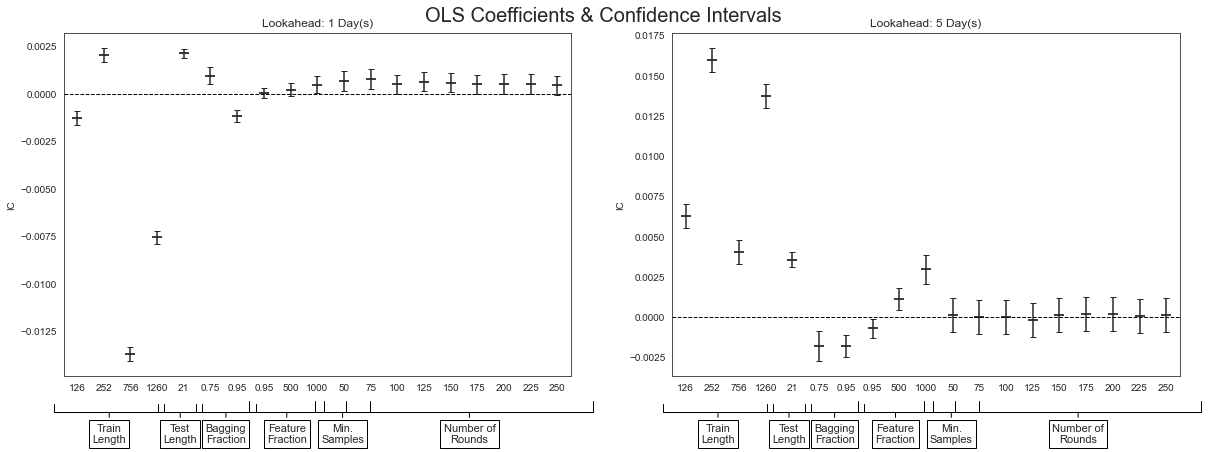

In [36]:
with sns.axes_style('white'):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
    axes = axes.flatten()
    for i, t in enumerate([1, 5]):
        visualize_lr_result(lin_reg[t], axes[i])
        axes[i].set_title(f'Lookahead: {t} Day(s)')
    fig.suptitle('OLS Coefficients & Confidence Intervals', fontsize=20)
    fig.subplots_adjust(top=.92)

In [37]:
ic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   train_length      9000 non-null   int64  
 1   test_length       9000 non-null   int64  
 2   bagging_fraction  9000 non-null   float64
 3   feature_fraction  9000 non-null   float64
 4   min_data_in_leaf  9000 non-null   int64  
 5   t                 9000 non-null   int64  
 6   rounds            9000 non-null   int64  
 7   ic                9000 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 562.6 KB


In [38]:
ic.groupby('t').apply(lambda x: x.nlargest(3, 'ic'))

train_length  test_length  bagging_fraction  feature_fraction  \
t                                                                        
1  1458           126           21              0.50              0.75   
   3258           126           21              0.50              0.75   
   1467           126           21              0.50              0.75   
5  5002          1260            5              0.95              0.95   
   5011          1260            5              0.95              0.95   
   5038          1260            5              0.95              0.95   
10 6867           126           21              0.50              0.75   
   6840           126           21              0.50              0.75   
   6868           126           21              0.50              0.75   
21 8304          1260           21              0.95              0.95   
   8313          1260           21              0.95              0.95   
   8322          1260           21              0.95              0.95   

         min_data_in_leaf   t  rounds        ic  
t                                                
1  1458               250   1      75  0.006334  
   3258               250   1      75  0.006334  
   1467               250   1     100  0.005872  
5  5002               250   5     400  0.019557  
   5011               250   5     425  0.019421  
   5038               250   5     500  0.019379  
10 6867               250  10     100  0.049494  
   6840               250  10      25  0.049454  
   6868               500  10     100  0.049299  
21 8304               500  21      75  0.057233  
   8313               500  21     100  0.056903  
   8322               500  21     125  0.056548

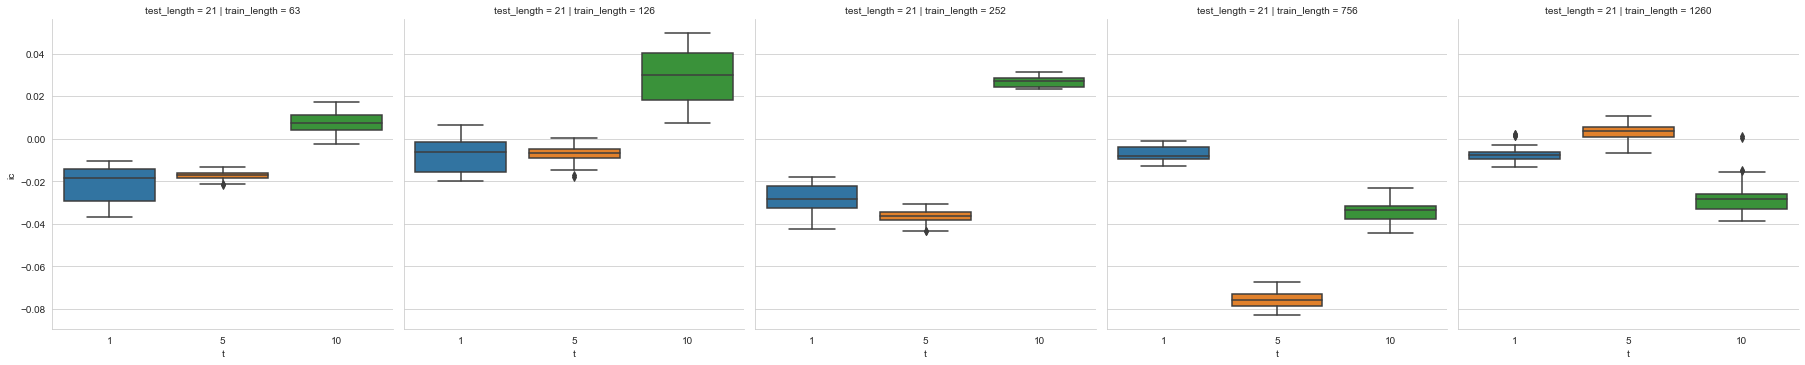

In [39]:
g = sns.catplot(x='t', y='ic', col='train_length', row='test_length',
                data=ic[(ic.test_length == 21) & (ic.t < 21)], kind='box')

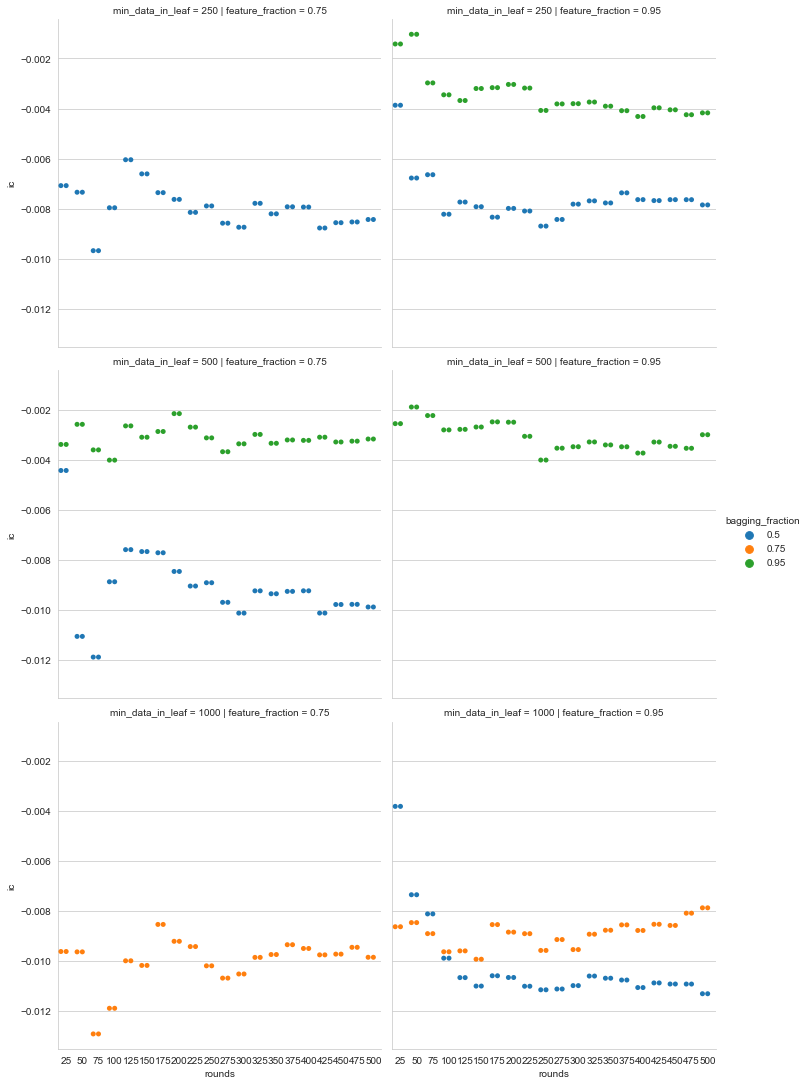

In [40]:
t = 1
train_length = 756
test_length = 21
g = sns.catplot(x='rounds', y='ic', col='feature_fraction', hue='bagging_fraction', row='min_data_in_leaf',
    data=ic[(ic.t == t) & (ic.train_length == train_length) & (ic.test_length == test_length)], kind='swarm');

In [41]:
lr_metrics = pd.read_csv(results_path / 'lin_reg_performance.csv')
lr_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lookahead     40 non-null     int64  
 1   train_length  40 non-null     int64  
 2   test_length   40 non-null     int64  
 3   ic_by_day     40 non-null     float64
 4   ic            40 non-null     float64
dtypes: float64(2), int64(3)
memory usage: 1.7 KB


In [42]:
daily_ic_avg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   t                 7200 non-null   int64  
 1   train_length      7200 non-null   int64  
 2   test_length       7200 non-null   int64  
 3   bagging_fraction  7200 non-null   float64
 4   feature_fraction  7200 non-null   float64
 5   min_data_in_leaf  7200 non-null   int64  
 6   rounds            7200 non-null   int64  
 7   ic                7200 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 450.1 KB


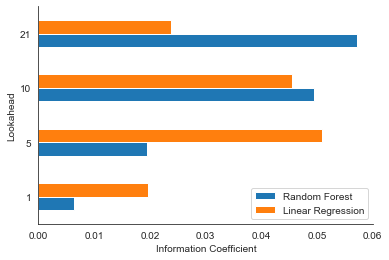

In [43]:
with sns.axes_style("white"):
    ax = (ic.groupby('t').ic.max().to_frame('Random Forest')
     .join(lr_metrics.groupby('lookahead').ic.max().to_frame('Linear Regression')).plot.barh())
    ax.set_ylabel('Lookahead')
    ax.set_xlabel('Information Coefficient')
    sns.despine()

In [44]:
param_cols = ['train_length', 'test_length', 'bagging_fraction',
              'feature_fraction', 'min_data_in_leaf', 'rounds']
def get_params(data, t=5, best=0):
    df = data[data.t == t].sort_values('ic', ascending=False).iloc[best]
    df = df.loc[param_cols]
    rounds = int(df.rounds)
    params = pd.to_numeric(df.drop('rounds'))
    return params, rounds
base_params = dict(boosting_type='rf', objective='regression', bagging_freq=1, verbose=-1)

store = Path(results_path / 'predictions.h5')

In [47]:
for lookahead in [1, 5, 10, 21]:
    if lookahead > 1:
        continue
    print(f'\nLookahead: {lookahead:02}')
    data = (pd.read_hdf('data/data.h5', 'stooq/japan/equities'))
    labels = sorted(data.filter(like='fwd').columns)
    features = data.columns.difference(labels).tolist()
    label = f'fwd_ret_{lookahead:02}'
    data = data.loc[:, features + [label]].dropna()

    categoricals = ['year', 'weekday', 'month']
    for feature in categoricals:
        data[feature] = pd.factorize(data[feature], sort=True)[0]

    lgb_data = lgb.Dataset(data=data[features], label=data[label], categorical_feature=categoricals,
                           free_raw_data=False)

    for position in range(10):
        params, num_boost_round = get_params(daily_ic_avg, t=lookahead, best=position)
        params = params.to_dict()
        params['min_data_in_leaf'] = int(params['min_data_in_leaf'])
        train_length = int(params.pop('train_length'))
        test_length = int(params.pop('test_length'))
        params.update(base_params)

        print(f'\tPosition: {position:02}')

        n_splits = int(2 * YEAR / test_length)
        cv = MultipleTimeSeriesCV(n_splits=n_splits, test_period_length=test_length, lookahead=lookahead,
                                  train_period_length=train_length)

        predictions = []
        start = time()
        for i, (train_idx, test_idx) in enumerate(cv.split(X=data), 1):
            train_set = lgb_data.subset(used_indices=train_idx.tolist(), params=params).construct()

            model = lgb.train(params=params, train_set=train_set, num_boost_round=num_boost_round,
                              verbose_eval=False)

            test_set = data.iloc[test_idx, :]
            y_test = test_set.loc[:, label].to_frame('y_test')
            y_pred = model.predict(test_set.loc[:, model.feature_name()])
            predictions.append(y_test.assign(prediction=y_pred))

        if position == 0:
            test_predictions = (pd.concat(predictions).rename(columns={'prediction': position}))
        else:
            test_predictions[position] = pd.concat(predictions).prediction


    by_day = test_predictions.groupby(level='date')
    for position in range(10):
        if position == 0:
            ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0]).to_frame()
        else:
            ic_by_day[position] = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0])

    test_predictions.to_hdf(store, f'test/{lookahead:02}')


Lookahead: 01
	Position: 00
	Position: 01
	Position: 02
	Position: 03
	Position: 04
	Position: 05
	Position: 06
	Position: 07
	Position: 08
	Position: 09
